In [1]:
!nvidia-smi

Sat Sep 14 13:48:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             41W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.21.0

numpy       : 1.26.4
pandas      : 2.2.2
torch       : 2.4.0
transformers: 4.44.0



In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("/kaggle/input/google-play-reviews-of-top-25-productivity-tools/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,a4540892-992d-48e8-ac56-89aa4ac9199d,Pat Lentz,https://play-lh.googleusercontent.com/a/ACg8oc...,I used this app for many years and it worked f...,1,3,v11432,2024-05-23 12:01:14,"Hi Pat, we're truly sorry to hear about this! ...",2024-05-24 15:43:43,v11432,most_relevant,com.todoist
1,c591a9c3-fef3-4db6-96d2-8d45ab2cc852,Zach LaMarca,https://play-lh.googleusercontent.com/a-/ALV-U...,"Downloaded the app to try it, which it wanted ...",1,6,NaN,2024-07-17 15:46:03,NaN,NaN,NaN,most_relevant,com.todoist
2,864a3d8e-7863-4b28-9062-aed1b8e8281b,Darkest Love,https://play-lh.googleusercontent.com/a-/ALV-U...,Didn't notice ive used this app before (memory...,1,2,v10532,2022-10-11 22:15:26,Hello! We are very sorry to hear about the cra...,2022-10-13 13:01:14,v10532,most_relevant,com.todoist
3,7007f861-8aad-4070-b3f5-bf4f3bee6a00,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I'm doing what I decry - leaving a bad review ...,1,2,NaN,2019-01-11 01:56:10,NaN,NaN,NaN,most_relevant,com.todoist
4,a676cc0e-0e50-431f-bc05-d513d627e208,Amber Knowlton,https://play-lh.googleusercontent.com/a/ACg8oc...,"What is the point of a ""To Do"" list without re...",1,10,NaN,2021-03-18 15:31:37,NaN,NaN,NaN,most_relevant,com.todoist


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28014 entries, 0 to 28013
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              28014 non-null  object
 1   userName              28012 non-null  object
 2   userImage             28014 non-null  object
 3   content               28009 non-null  object
 4   score                 28014 non-null  int64 
 5   thumbsUpCount         28014 non-null  int64 
 6   reviewCreatedVersion  24967 non-null  object
 7   at                    28014 non-null  object
 8   replyContent          7923 non-null   object
 9   repliedAt             7923 non-null   object
 10  appVersion            24967 non-null  object
 11  sortOrder             28014 non-null  object
 12  appId                 28014 non-null  object
dtypes: int64(2), object(11)
memory usage: 2.8+ MB


In [9]:
df_cleaned = df.dropna(subset=['content'])

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
token_lens = []

for txt in df_cleaned.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


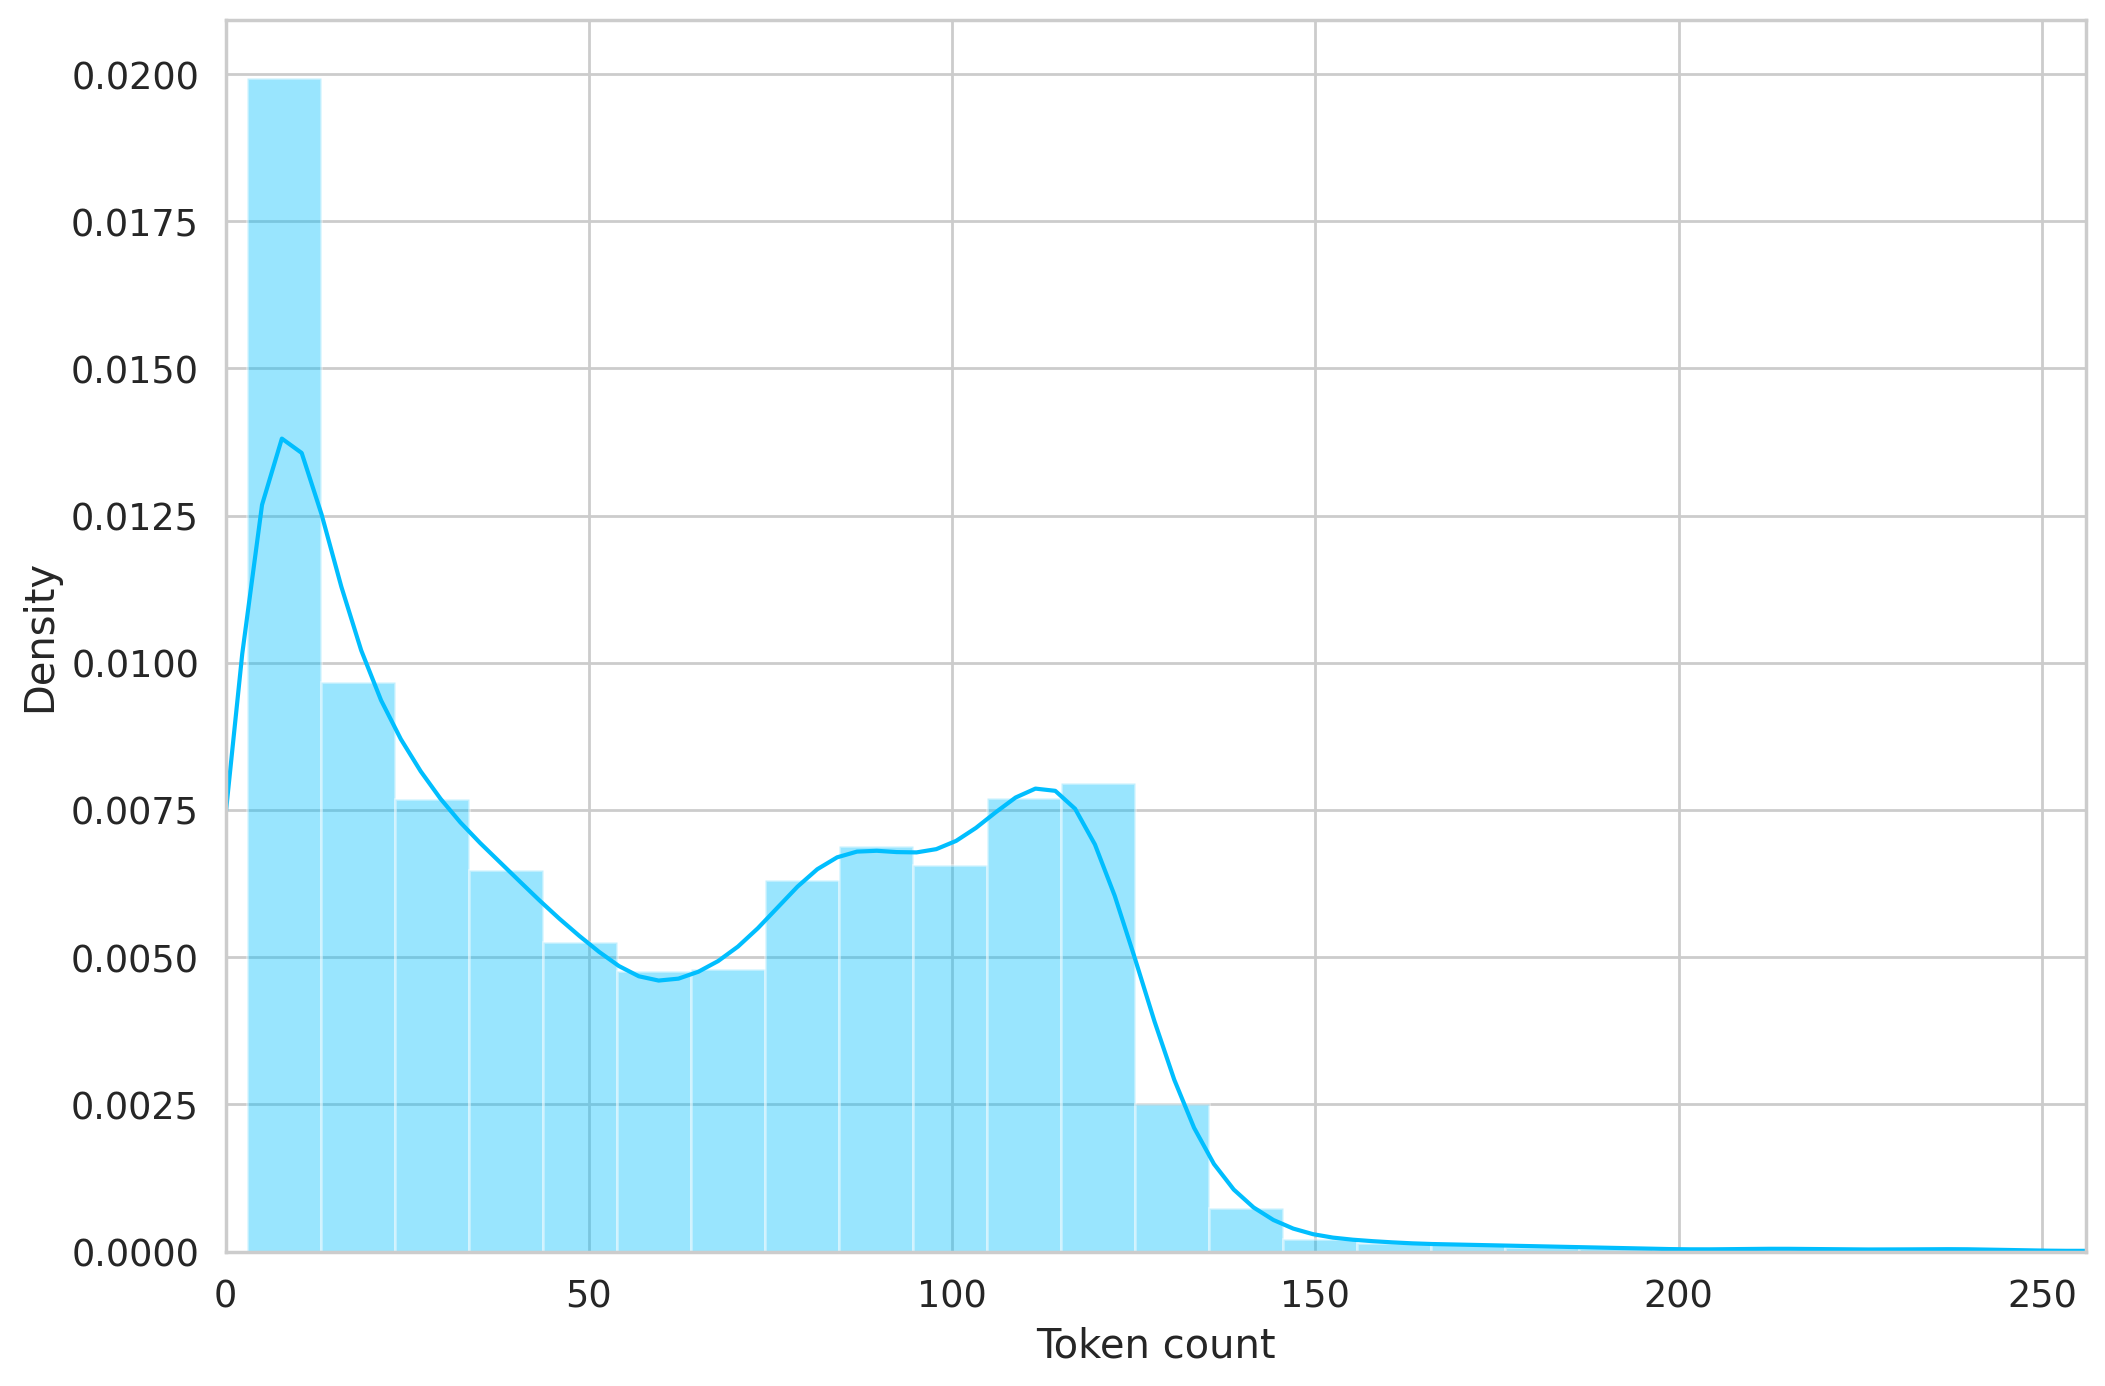

In [13]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [14]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df_cleaned['sentiment'] = df_cleaned.score.apply(to_sentiment)

In [15]:
MAX_LEN = 150

In [16]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
              review,
              add_special_tokens=True,
              max_length=self.max_len,
              return_token_type_ids=False,
              pad_to_max_length=True,
              return_attention_mask=True,
              return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [17]:
df_train, df_test = train_test_split(df_cleaned, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [18]:
df_train.shape, df_val.shape, df_test.shape

((22407, 14), (2801, 14), (2801, 14))

In [19]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'sortOrder', 'appId'],
      dtype='object')

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
     

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# Model Building

In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [25]:
bert_model.config.hidden_size # no of hidden units in feed forward layers

768

In [26]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        # Get the last_hidden_state and pooled_output from the BERT model
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Extract the pooled_output (second item in the outputs tuple)
        pooled_output = outputs.pooler_output
        
        # Apply dropout and pass through the classifier
        output = self.drop(pooled_output)
        return self.out(output)

Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

In [27]:
class_names = ['negative', 'neutral', 'positive']

In [28]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [29]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [30]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1725, 0.2001, 0.6274],
        [0.1517, 0.3052, 0.5430],
        [0.1952, 0.2927, 0.5121],
        [0.1784, 0.1793, 0.6423],
        [0.3455, 0.3239, 0.3306],
        [0.3461, 0.2648, 0.3891],
        [0.2341, 0.2918, 0.4740],
        [0.1999, 0.4392, 0.3608],
        [0.2536, 0.2594, 0.4871],
        [0.2070, 0.2828, 0.5102],
        [0.2194, 0.2448, 0.5358],
        [0.5117, 0.2203, 0.2680],
        [0.2239, 0.2913, 0.4848],
        [0.1943, 0.3033, 0.5024],
        [0.1760, 0.2971, 0.5269],
        [0.2555, 0.2429, 0.5016]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [31]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have some recommendations about hyperparameters for fine-tuning:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.



In [32]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm_

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
     

Epoch 1/10
----------
Train loss 0.8019794079340159 accuracy 0.6296246708617843
Val   loss 0.7321825018999252 accuracy 0.6669046769011068

Epoch 2/10
----------
Train loss 0.5670219409644476 accuracy 0.7666800553398492
Val   loss 0.7243945141407576 accuracy 0.6897536594073546

Epoch 3/10
----------
Train loss 0.39200664047207645 accuracy 0.8526353371714197
Val   loss 0.8818241691386158 accuracy 0.6840414137807926

Epoch 4/10
----------
Train loss 0.285762244526717 accuracy 0.9019502833935824
Val   loss 1.0307431826367974 accuracy 0.7040342734737594

Epoch 5/10
----------
Train loss 0.2299003914416735 accuracy 0.9270317311554425
Val   loss 1.2730279140682383 accuracy 0.7036772581220992

Epoch 6/10
----------
Train loss 0.17976196700061267 accuracy 0.9453742134154506
Val   loss 1.5025233756750822 accuracy 0.7051053195287398

Epoch 7/10
----------
Train loss 0.1469458995354676 accuracy 0.957066987994823
Val   loss 1.7392097960381017 accuracy 0.7122456265619422

Epoch 8/10
----------
Train

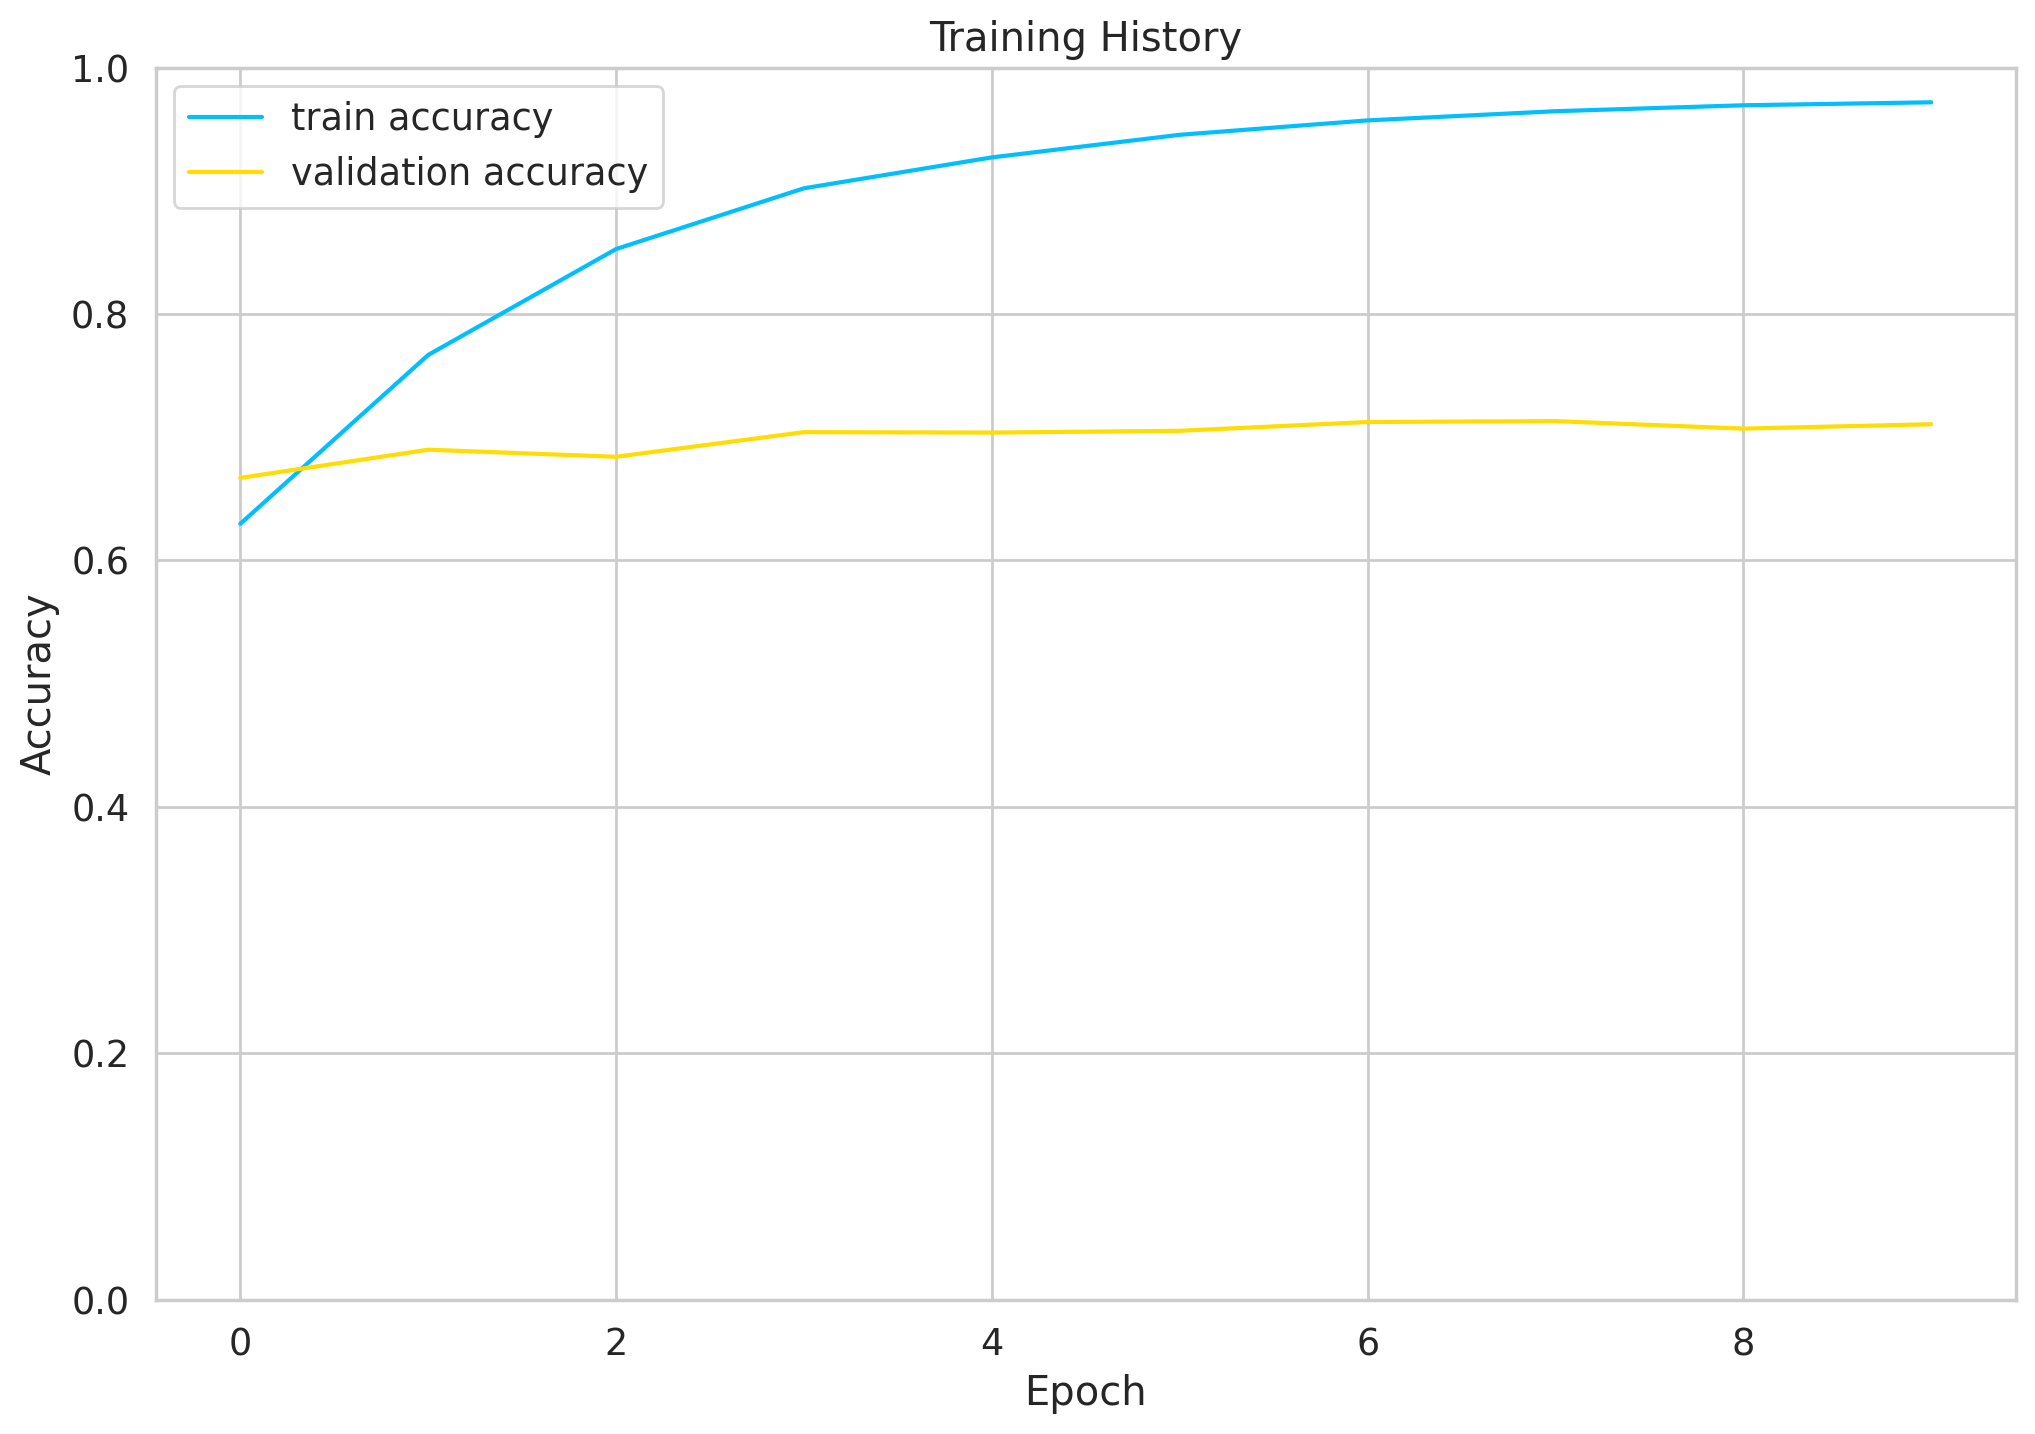

In [41]:
train_acc_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in history['train_acc']]
val_acc_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in history['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')

plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])  # Assuming accuracy ranges between 0 and 1
plt.show()

In [42]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()
     

0.7168868261335237

In [43]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return review_texts, predictions, prediction_probs, real_values

In [44]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [45]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.72      0.74      1001
     neutral       0.60      0.65      0.62       885
    positive       0.79      0.77      0.78       915

    accuracy                           0.72      2801
   macro avg       0.72      0.72      0.72      2801
weighted avg       0.72      0.72      0.72      2801



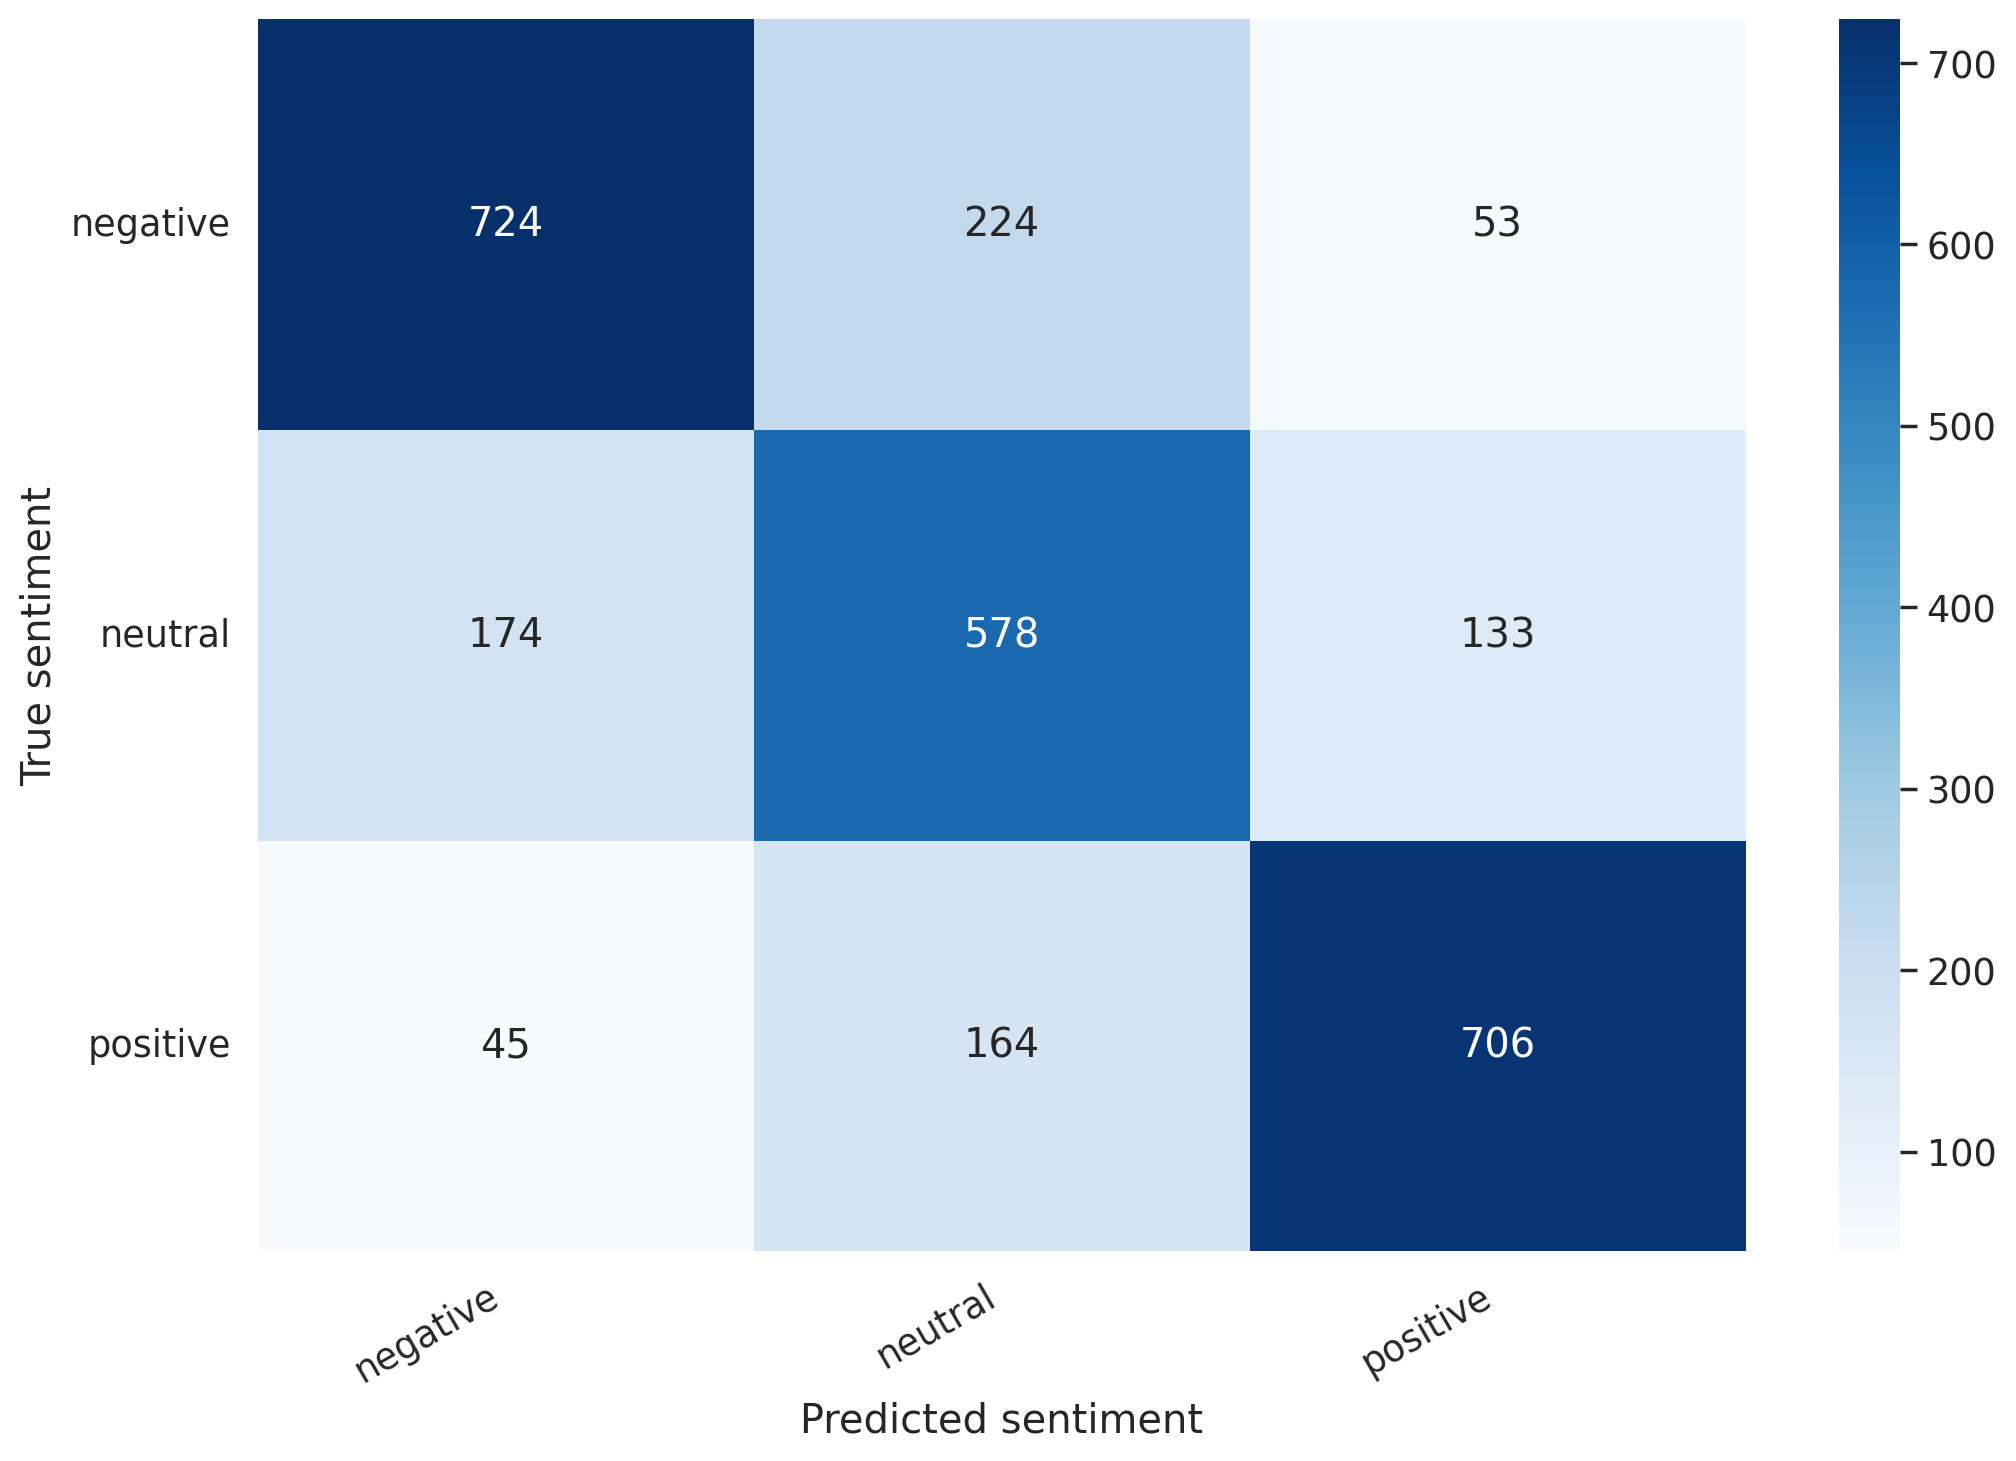

In [46]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [47]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [48]:

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Even better of the notifications consistently got you to the right
location in docs - it's a bit inconsistent - but a great app and
service!

True sentiment: positive


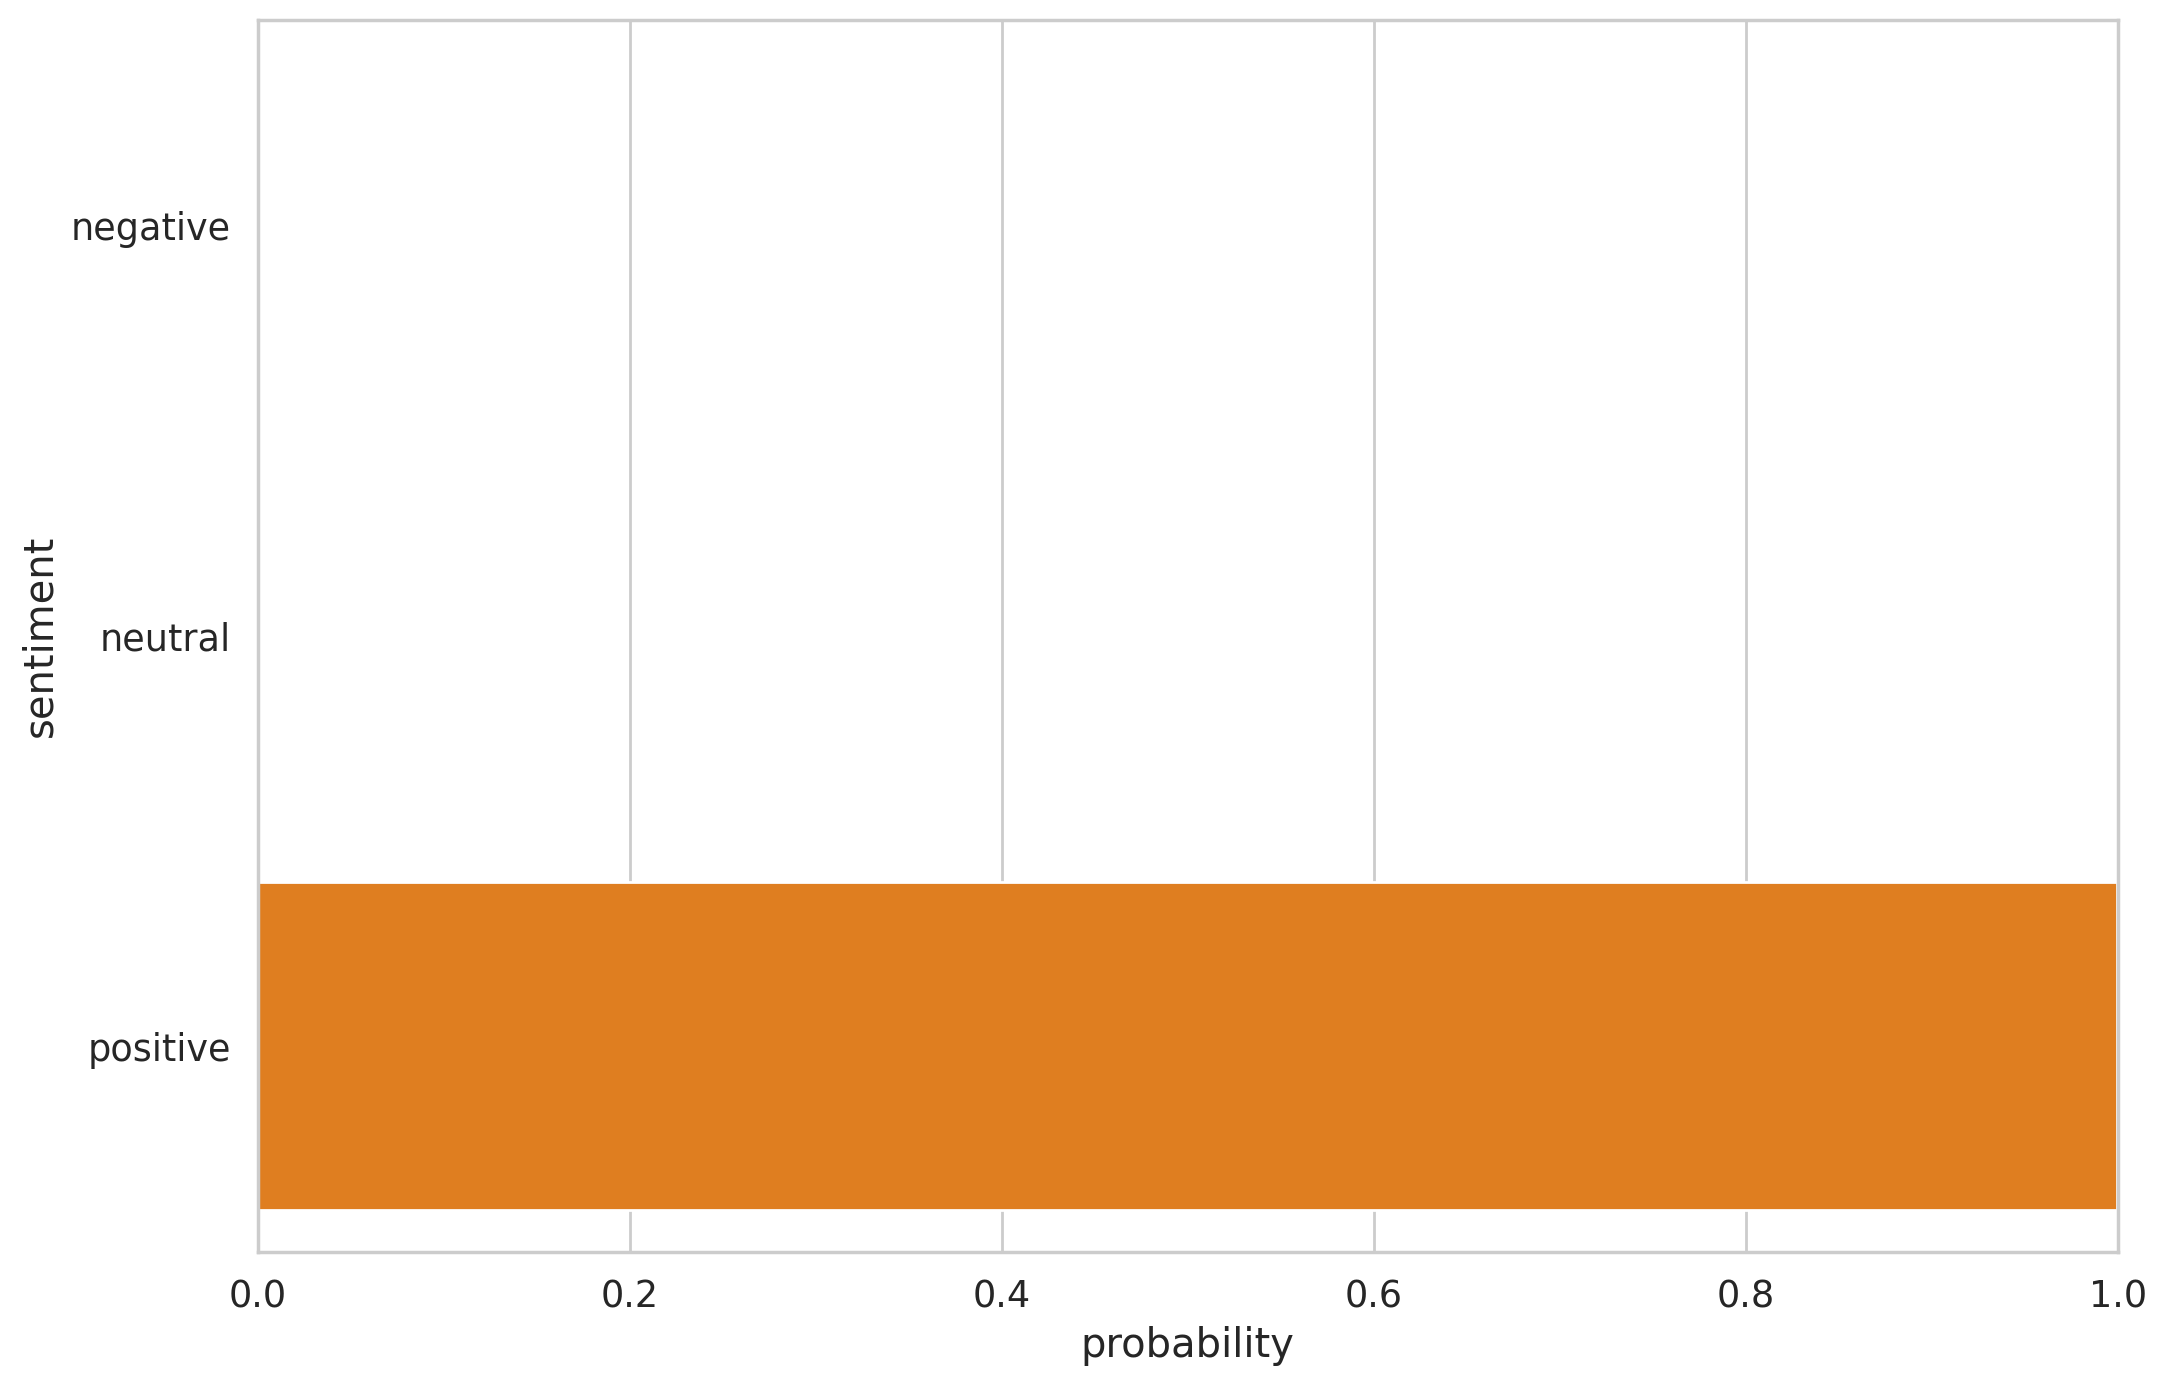

In [49]:

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [50]:
review_text = "I love completing my todos! Best app ever!!!"


In [51]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
     

In [52]:

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


In [53]:
review_text = "The app is useful but expensive... and kinda laggy"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
     

Review text: The app is useful but expensive... and kinda laggy
Sentiment  : neutral
